In [ ]:
import os

print(os.getcwd())

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(path)

print(os.getcwd())

/content
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
print("Installing necessary dependency packages...")
!pip install librosa scikit-learn pandas numpy matplotlib seaborn tqdm imbalanced-learn -q

import os
import warnings
from pathlib import Path
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(42)

print("Dependencies installation completed!")

Installing necessary dependency packages...
Dependencies installation completed!


In [ ]:
import tensorflow as tf

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


set_seeds(42)

In [ ]:
# Label Strategy
DATASET_PATH = "ESC-50-master"
OUTPUT_DIR = "processed_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)



SMART_HOME_CRITICAL_ANOMALIES = [
    # Security threats (8)
    'glass_breaking', 'siren', 'chainsaw', 'hand_saw',
    'helicopter', 'car_horn', 'engine', 'train', 'crackling_fire',

    # Intrusion threats (2)
    'door_knock', 'airplane',

    # Emergency situations (4)
    'crying_baby', 'coughing', 'sneezing'
]

# Define complete ESC-50 category list
ALL_ESC50_CATEGORIES = [
    # Animal sounds
    'dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow',
    # Natural environment
    'rain', 'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds',
    'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm',
    # Human sounds
    'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing',
    'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping',
    # Indoor sounds
    'door_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks',
    'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm',
    'clock_tick', 'glass_breaking',
    # External sounds
    'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine',
    'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw'
]

# Select strategy
STRATEGY = "smart_home_critical"  # Options: "smart_home_balanced", "smart_home_strict", "smart_home_critical"

if STRATEGY == "smart_home_balanced":
    NORMAL_CATEGORIES = SMART_HOME_NORMAL_CATEGORIES
    print(f"Using Smart Home Balanced Strategy: {len(NORMAL_CATEGORIES)} normal categories")
    print("   Includes: Natural environment + Household appliances + Daily life + Pet sounds")

elif STRATEGY == "smart_home_strict":
    NORMAL_CATEGORIES = SMART_HOME_STRICT_CATEGORIES
    print(f"Using Smart Home Strict Strategy: {len(NORMAL_CATEGORIES)} normal categories")
    print("   Includes: Only core household daily sounds")

else:  # smart_home_critical
    # Reverse strategy: everything except serious threats is normal
    NORMAL_CATEGORIES = [cat for cat in ALL_ESC50_CATEGORIES if cat not in SMART_HOME_CRITICAL_ANOMALIES]
    print(f"Using Smart Home Threat-Oriented Strategy: {len(SMART_HOME_CRITICAL_ANOMALIES)} anomaly categories")
    print("   Anomalies: Only real security threats and emergency situations")

print(f"Normal categories: {NORMAL_CATEGORIES}")

# Expected data distribution
if STRATEGY == "smart_home_balanced":
    expected_normal = len(SMART_HOME_NORMAL_CATEGORIES) * 40  # 40 samples per category
    expected_anomaly = (50 - len(SMART_HOME_NORMAL_CATEGORIES)) * 40
    print(f"Expected distribution: {expected_normal} normal, {expected_anomaly} anomaly ({len(SMART_HOME_NORMAL_CATEGORIES)/50*100:.0f}% normal)")

elif STRATEGY == "smart_home_strict":
    expected_normal = len(SMART_HOME_STRICT_CATEGORIES) * 40
    expected_anomaly = (50 - len(SMART_HOME_STRICT_CATEGORIES)) * 40
    print(f"Expected distribution: {expected_normal} normal, {expected_anomaly} anomaly ({len(SMART_HOME_STRICT_CATEGORIES)/50*100:.0f}% normal)")

else:  # smart_home_critical
    expected_anomaly = len(SMART_HOME_CRITICAL_ANOMALIES) * 40
    expected_normal = (50 - len(SMART_HOME_CRITICAL_ANOMALIES)) * 40
    print(f"Expected distribution: {expected_normal} normal, {expected_anomaly} anomaly ({len(SMART_HOME_CRITICAL_ANOMALIES)/50*100:.0f}% anomaly)")

# Display anomaly categories (applies to all strategies)
ANOMALY_CATEGORIES = [cat for cat in ALL_ESC50_CATEGORIES if cat not in NORMAL_CATEGORIES]
print(f"Anomaly categories: {ANOMALY_CATEGORIES}")
print(f"Number of anomaly categories: {len(ANOMALY_CATEGORIES)}")

Using Smart Home Threat-Oriented Strategy: 14 anomaly categories
   Anomalies: Only real security threats and emergency situations
Normal categories: ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'rain', 'sea_waves', 'crickets', 'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'clapping', 'breathing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'church_bells', 'fireworks']
Expected distribution: 1440 normal, 560 anomaly (28% anomaly)
Anomaly categories: ['crackling_fire', 'crying_baby', 'sneezing', 'coughing', 'door_knock', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'airplane', 'hand_saw']
Number of anomaly categories: 14


In [ ]:
# Improved Data Loading
def load_esc50_with_labels():
    """Load ESC-50 data and create smart home anomaly detection labels"""
    print("Loading ESC-50 data...")

    # Read metadata
    meta_path = os.path.join(DATASET_PATH, 'meta', 'esc50.csv')
    meta_df = pd.read_csv(meta_path)

    # Create anomaly detection labels - using correct NORMAL_CATEGORIES
    meta_df['is_normal'] = meta_df['category'].isin(NORMAL_CATEGORIES).astype(int)

    # Basic statistics
    normal_count = meta_df['is_normal'].sum()
    anomaly_count = len(meta_df) - normal_count

    print(f"Data loading completed:")
    print(f"   Total samples: {len(meta_df)}")
    print(f"   Normal: {normal_count} ({normal_count/len(meta_df)*100:.1f}%)")
    print(f"   Anomaly: {anomaly_count} ({anomaly_count/len(meta_df)*100:.1f}%)")

    return meta_df

# Use simplified version
meta_df = load_esc50_with_labels()

meta_df

Loading ESC-50 data...
Data loading completed:
   Total samples: 2000
   Normal: 1440 (72.0%)
   Anomaly: 560 (28.0%)


,filename,fold,target,category,esc10,src_file,take,is_normal
0,1-100032-A-0.wav,1,0,dog,True,100032,A,1
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1
...,...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B,1
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A,1
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A,1
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A,1


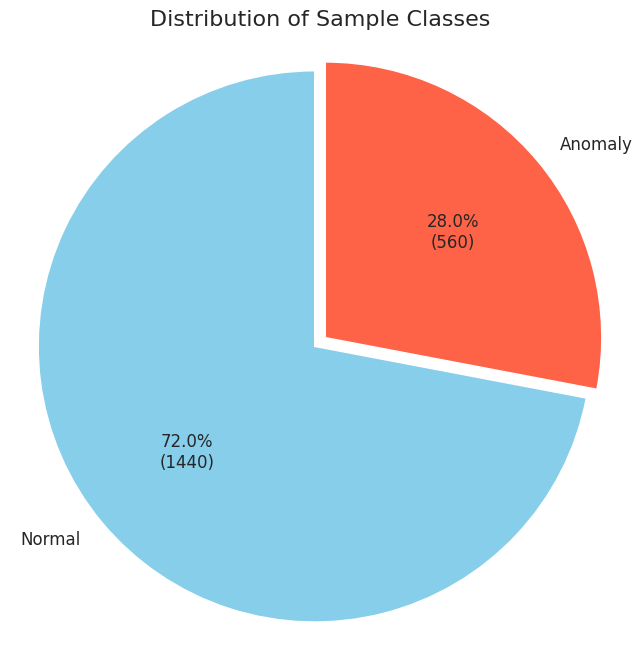

In [ ]:
class_counts = meta_df['is_normal'].value_counts()
labels = class_counts.index.map({1: 'Normal', 0: 'Anomaly'})
sizes = class_counts.values
colors = ['#87CEEB', '#FF6347']
explode = (0.05, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(sizes) / 100),
        shadow=False, startangle=90, textprops={'fontsize': 12})


plt.title('Distribution of Sample Classes', fontsize=16)
plt.axis('equal')

plt.savefig('figure_5_1_piechart.png', dpi=300, bbox_inches='tight')

In [ ]:
# Feature Extraction + Caching
import numpy as np
import pandas as pd
import librosa
import scipy.stats
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import pickle
import hashlib
import warnings
warnings.filterwarnings('ignore')

def extract_comprehensive_features_fast(signal, sr):
    """Fast extraction of audio features"""
    features = {}
    hop_length = 512
    n_fft = 1024

    # 1. MFCC Features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13,
                                hop_length=hop_length, n_fft=n_fft)
    mfcc_stats = np.array([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        scipy.stats.skew(mfcc, axis=1), scipy.stats.kurtosis(mfcc, axis=1)
    ])

    for i in range(13):
        features[f'mfcc_{i}_mean'] = mfcc_stats[0, i]
        features[f'mfcc_{i}_std'] = mfcc_stats[1, i]
        features[f'mfcc_{i}_skew'] = mfcc_stats[2, i]
        features[f'mfcc_{i}_kurt'] = mfcc_stats[3, i]

    # 2. Spectral Features
    stft = librosa.stft(signal, hop_length=hop_length, n_fft=n_fft)
    magnitude = np.abs(stft)

    spectral_centroids = librosa.feature.spectral_centroid(S=magnitude, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=magnitude, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

    spectral_rolloff = librosa.feature.spectral_rolloff(S=magnitude, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)

    # 3. Rhythm & Energy
    zcr = librosa.feature.zero_crossing_rate(signal, hop_length=hop_length)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)

    rms = librosa.feature.rms(y=signal, hop_length=hop_length)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)

    # 4. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(S=magnitude, sr=sr, n_bands=6)
    for i in range(contrast.shape[0]):
        features[f'contrast_{i}_mean'] = np.mean(contrast[i])

    # 5. Chroma Features
    chroma = librosa.feature.chroma_stft(S=magnitude, sr=sr)
    for i in range(12):
        features[f'chroma_{i}_mean'] = np.mean(chroma[i])

    # 6. Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=32,
                                              hop_length=hop_length, n_fft=n_fft)
    mel_spec_db = librosa.power_to_db(mel_spec)
    features['mel_mean'] = np.mean(mel_spec_db)
    features['mel_std'] = np.std(mel_spec_db)
    features['mel_max'] = np.max(mel_spec_db)
    features['mel_min'] = np.min(mel_spec_db)

    # Handle invalid values
    for key, value in features.items():
        if np.isnan(value) or np.isinf(value):
            features[key] = 0.0

    return features

def process_single_file(args):
    """Process a single audio file"""
    file_info, audio_path = args
    try:
        file_path = audio_path / file_info['filename']
        signal, sr = librosa.load(file_path, sr=16000, duration=5.0)

        features = extract_comprehensive_features_fast(signal, sr)
        features.update({
            'filename': file_info['filename'],
            'category': file_info['category'],
            'is_normal': file_info['is_normal']
        })

        return features

    except Exception as e:
        print(f"Failed to process: {file_info['filename']} - {e}")
        return None

def get_cache_filename(meta_df, sample_size):
    """Generate cache filename"""
    data_hash = hashlib.md5(str(meta_df.shape).encode()).hexdigest()[:8]
    return f"features_cache_{data_hash}_s{sample_size}.pkl"

def load_from_cache(cache_file):
    """Load from cache"""
    if Path(cache_file).exists():
        try:
            with open(cache_file, 'rb') as f:
                features_df = pickle.load(f)
            print(f"Loaded from cache: {features_df.shape}")
            return features_df
        except:
            pass
    return None

def save_to_cache(features_df, cache_file):
    """Save to cache"""
    try:
        with open(cache_file, 'wb') as f:
            pickle.dump(features_df, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Saved to cache: {cache_file}")
    except Exception as e:
        print(f"Cache save failed: {e}")

def quick_load_features(meta_df, sample_size=2000):
    """Smart feature loader (uses cache if available)"""

    # Check cache
    cache_file = get_cache_filename(meta_df, sample_size)
    cached_features = load_from_cache(cache_file)
    if cached_features is not None:
        return cached_features

    print(f"Extracting features ({sample_size} samples)...")

    # Smart sampling
    if sample_size < len(meta_df):
        normal_samples = meta_df[meta_df['is_normal'] == 1]
        abnormal_samples = meta_df[meta_df['is_normal'] == 0]

        normal_size = int(sample_size * 0.8)
        abnormal_size = sample_size - normal_size

        if len(normal_samples) >= normal_size and len(abnormal_samples) >= abnormal_size:
            sample_meta = pd.concat([
                normal_samples.sample(n=normal_size, random_state=42),
                abnormal_samples.sample(n=abnormal_size, random_state=42)
            ]).reset_index(drop=True)
        else:
            sample_meta = meta_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        sample_meta = meta_df.reset_index(drop=True)

    print(f"   Normal: {sum(sample_meta['is_normal'])} | Abnormal: {len(sample_meta) - sum(sample_meta['is_normal'])}")

    # Parallel extraction
    audio_path = Path(DATASET_PATH) / 'audio'
    file_args = [(row.to_dict(), audio_path) for _, row in sample_meta.iterrows()]
    n_workers = max(1, mp.cpu_count() - 1)

    features_list = []
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(process_single_file, arg) for arg in file_args]

        for future in tqdm(futures, desc="Extracting Features"):
            try:
                result = future.result(timeout=30)
                if result is not None:
                    features_list.append(result)
            except Exception as e:
                print(f"   Task failed: {e}")

    # Create DataFrame
    features_df = pd.DataFrame(features_list)
    print(f"Completed: {len(features_df)} samples")

    # Save to cache
    save_to_cache(features_df, cache_file)

    return features_df

# Main entry
if __name__ == "__main__":
    print("SOTA Feature Extraction + Smart Caching")
    print("="*40)

    # Load or extract features
    features_df = quick_load_features(meta_df, sample_size=2000)

    print(f"\nFeature Matrix: {features_df.shape}")
    print("="*40)

SOTA Feature Extraction + Smart Caching
Loaded from cache: (2000, 88)

Feature Matrix: (2000, 88)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def test_models_single_fold(X_train, X_val, y_train, y_val):
    """
    Test models on a single fold and return a dictionary of performance metrics.
    """
    results = {}

    # --- 1. Random Forest ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    y_proba = rf.predict_proba(X_val)[:, 0]  # Probability for anomaly class (label=0)

    results['RandomForest'] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, pos_label=0, zero_division=0),
        'recall': recall_score(y_val, y_pred, pos_label=0, zero_division=0),
        'f1': f1_score(y_val, y_pred, pos_label=0, zero_division=0),
        'auc': roc_auc_score((y_val == 0), y_proba)
    }

    # --- 2. Isolation Forest ---
    anomaly_ratio_train = np.mean(y_train == 0)
    iso_forest = IsolationForest(contamination=max(0.01, anomaly_ratio_train), random_state=42)
    iso_forest.fit(X_train)
    iso_pred = iso_forest.predict(X_val)
    y_pred_iso = np.where(iso_pred == -1, 0, 1)
    y_scores_iso = -iso_forest.score_samples(X_val)

    results['IsolationForest'] = {
        'accuracy': accuracy_score(y_val, y_pred_iso),
        'precision': precision_score(y_val, y_pred_iso, pos_label=0, zero_division=0),
        'recall': recall_score(y_val, y_pred_iso, pos_label=0, zero_division=0),
        'f1': f1_score(y_val, y_pred_iso, pos_label=0, zero_division=0),
        'auc': roc_auc_score((y_val == 0), y_scores_iso)
    }

    # --- 3. One-Class SVM ---
    X_train_normal = X_train[y_train == 1]
    oc_svm = OneClassSVM(nu=max(0.01, anomaly_ratio_train), kernel="rbf")
    oc_svm.fit(X_train_normal)
    svm_pred = oc_svm.predict(X_val)
    y_pred_svm = np.where(svm_pred == -1, 0, 1)
    y_scores_svm = -oc_svm.decision_function(X_val)

    results['OneClassSVM'] = {
        'accuracy': accuracy_score(y_val, y_pred_svm),
        'precision': precision_score(y_val, y_pred_svm, pos_label=0, zero_division=0),
        'recall': recall_score(y_val, y_pred_svm, pos_label=0, zero_division=0),
        'f1': f1_score(y_val, y_pred_svm, pos_label=0, zero_division=0),
        'auc': roc_auc_score((y_val == 0), y_scores_svm)
    }

    # --- 4. Local Outlier Factor ---
    lof = LocalOutlierFactor(contamination=max(0.01, anomaly_ratio_train), novelty=True)
    lof.fit(X_train_normal)
    lof_pred = lof.predict(X_val)
    y_pred_lof = np.where(lof_pred == -1, 0, 1)
    y_scores_lof = -lof.decision_function(X_val)

    results['LOF'] = {
        'accuracy': accuracy_score(y_val, y_pred_lof),
        'precision': precision_score(y_val, y_pred_lof, pos_label=0, zero_division=0),
        'recall': recall_score(y_val, y_pred_lof, pos_label=0, zero_division=0),
        'f1': f1_score(y_val, y_pred_lof, pos_label=0, zero_division=0),
        'auc': roc_auc_score((y_val == 0), y_scores_lof)
    }

    return results

def kfold_validation(features_df, k=5):
    """
    K-Fold Cross Validation with comprehensive metrics for each model.
    """
    print(f"K-Fold Cross Validation (k={k}) with Comprehensive Metrics...")

    # --- Data Preparation ---
    feature_cols = [col for col in features_df.columns if col not in ['filename', 'category', 'is_normal', 'fold']]
    X = features_df[feature_cols].values
    y = features_df['is_normal'].values
    print(f"   Feature dimensions: {X.shape}")
    print(f"   Label distribution: Normal={np.sum(y==1)}, Anomaly={np.sum(y==0)}")

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # --- Initialize result storage ---
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    all_results = {model_name: {metric: [] for metric in metrics}
                   for model_name in ['RandomForest', 'IsolationForest', 'OneClassSVM', 'LOF']}

    # --- Cross-validation loop ---
    for fold_num, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold_num}/{k}:")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_train_scaled = np.nan_to_num(X_train_scaled)
        X_val_scaled = np.nan_to_num(X_val_scaled)

        fold_results = test_models_single_fold(X_train_scaled, X_val_scaled, y_train, y_val)

        for model_name, model_metrics in fold_results.items():
            for metric_name, value in model_metrics.items():
                all_results[model_name][metric_name].append(value)

        # Show fold-wise F1 score (anomaly-focused)
        print(f"   Results (Anomaly F1): RF={fold_results['RandomForest']['f1']:.3f}, IF={fold_results['IsolationForest']['f1']:.3f}, OCSVM={fold_results['OneClassSVM']['f1']:.3f}, LOF={fold_results['LOF']['f1']:.3f}")

    # --- Final aggregated results ---
    print(f"\n{'='*60}")
    print("K-Fold Final Results (Mean ± Std Dev):")
    print(f"{'='*60}")
    print(f"{'Model':<18} | {'Accuracy':<18} | {'Precision (Anomaly)':<22} | {'Recall (Anomaly)':<20} | {'F1-Score (Anomaly)':<22} | {'AUC (Anomaly)':<18}")
    print("-" * 130)

    for model_name, model_metrics in all_results.items():
        acc_str = f"{np.mean(model_metrics['accuracy']):.3f} ± {np.std(model_metrics['accuracy']):.3f}"
        pre_str = f"{np.mean(model_metrics['precision']):.3f} ± {np.std(model_metrics['precision']):.3f}"
        rec_str = f"{np.mean(model_metrics['recall']):.3f} ± {np.std(model_metrics['recall']):.3f}"
        f1_str = f"{np.mean(model_metrics['f1']):.3f} ± {np.std(model_metrics['f1']):.3f}"
        auc_str = f"{np.mean(model_metrics['auc']):.3f} ± {np.std(model_metrics['auc']):.3f}"

        print(f"{model_name:<18} | {acc_str:<18} | {pre_str:<22} | {rec_str:<20} | {f1_str:<22} | {auc_str:<18}")

    return all_results

# Run cross-validation
kfold_results = kfold_validation(features_df)

K-Fold Cross Validation (k=5) with Comprehensive Metrics...
   Feature dimensions: (2000, 85)
   Label distribution: Normal=1440, Anomaly=560

Fold 1/5:
   Results (Anomaly F1): RF=0.527, IF=0.300, OCSVM=0.338, LOF=0.231

Fold 2/5:
   Results (Anomaly F1): RF=0.522, IF=0.370, OCSVM=0.349, LOF=0.283

Fold 3/5:
   Results (Anomaly F1): RF=0.462, IF=0.332, OCSVM=0.363, LOF=0.357

Fold 4/5:
   Results (Anomaly F1): RF=0.580, IF=0.319, OCSVM=0.343, LOF=0.315

Fold 5/5:
   Results (Anomaly F1): RF=0.416, IF=0.308, OCSVM=0.361, LOF=0.323

K-Fold Final Results (Mean ± Std Dev):
Model              | Accuracy           | Precision (Anomaly)    | Recall (Anomaly)     | F1-Score (Anomaly)     | AUC (Anomaly)     
----------------------------------------------------------------------------------------------------------------------------------
RandomForest       | 0.801 ± 0.014      | 0.835 ± 0.023          | 0.361 ± 0.056        | 0.501 ± 0.057          | 0.870 ± 0.018     
IsolationForest    | 0.6

In [ ]:
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

def smart_data_augmentation(X, y, factor=3.0):
    """Enhanced data augmentation"""
    minority_idx = np.where(y == 0)[0]
    if len(minority_idx) == 0:
        return X, y

    n_augment = min(int(factor * len(minority_idx)), len(X))
    aug_idx = np.random.choice(minority_idx, n_augment, replace=True)

    # Multiple augmentation strategies
    X_aug_list = []
    for i, idx in enumerate(aug_idx):
        if i % 3 == 0:
            # Gaussian noise
            aug_sample = X[idx] + np.random.normal(0, 0.01, X.shape[1])
        elif i % 3 == 1:
            # Feature perturbation
            aug_sample = X[idx].copy()
            mask = np.random.random(X.shape[1]) < 0.15
            aug_sample[mask] *= np.random.uniform(0.85, 1.15, np.sum(mask))
        else:
            # Mixed strategy
            aug_sample = X[idx] + np.random.normal(0, 0.005, X.shape[1])
            mask = np.random.random(X.shape[1]) < 0.1
            aug_sample[mask] *= np.random.uniform(0.9, 1.1, np.sum(mask))

        X_aug_list.append(aug_sample)

    X_aug = np.array(X_aug_list)
    y_aug = y[aug_idx]

    return np.vstack([X, X_aug]), np.hstack([y, y_aug])

def build_lightweight_model(input_dim):
    """Build optimized lightweight model (56→28→1)"""
    model = models.Sequential([
        layers.Dense(56, activation='relu', input_shape=(input_dim,), kernel_initializer='he_normal'),
        layers.Dropout(0.35),
        layers.Dense(28, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_lightweight_model(train_features_df, test_features_df, epochs=40, verbose=True):
    """Train optimized lightweight model"""

    if verbose:
        print("Optimized Lightweight Model Training (56→28→1)")

    # Prepare data
    feature_cols = [col for col in train_features_df.columns
                   if col not in ['filename', 'category', 'is_normal', 'fold']]

    X_train = train_features_df[feature_cols].values
    y_train = train_features_df['is_normal'].values
    X_test = test_features_df[feature_cols].values
    y_test = test_features_df['is_normal'].values

    # Data standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.nan_to_num(X_train_scaled, 0)
    X_test_scaled = np.nan_to_num(X_test_scaled, 0)

    if verbose:
        print(f"Training set: {X_train.shape}, Anomaly rate: {(1-np.mean(y_train))*100:.1f}%")
        print(f"Test set: {X_test.shape}, Anomaly rate: {(1-np.mean(y_test))*100:.1f}%")

    # Enhanced data augmentation
    X_train_aug, y_train_aug = smart_data_augmentation(X_train_scaled, y_train, factor=2.5)

    if verbose:
        print(f"Data augmentation: {len(X_train_scaled)} -> {len(X_train_aug)} samples")

    # Build and compile model
    model = build_lightweight_model(X_train_scaled.shape[1])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Optimized callbacks
    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, min_lr=1e-7, verbose=0)
    ]

    # Class weights - focus on anomaly detection optimization
    class_weight = {
        0: 2.0,  # Increased weight for anomaly class
        1: 1.0   # Normal class weight
    }

    # Train model
    if verbose:
        print("Starting training...")

    history = model.fit(
        X_train_aug, y_train_aug,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight,  # Add class weights
        callbacks=callbacks_list,
        verbose=1 if verbose else 0
    )

    # Test set evaluation
    test_probs = model.predict(X_test_scaled, verbose=0).flatten()
    test_preds = (test_probs > 0.5).astype(int)

    # Overall metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, test_preds),
        'auc': roc_auc_score(y_test, test_probs)
    }

    # Normal class metrics (label=1)
    normal_metrics = {
        'precision': precision_score(y_test, test_preds, pos_label=1, zero_division=0),
        'recall': recall_score(y_test, test_preds, pos_label=1, zero_division=0),
        'f1': f1_score(y_test, test_preds, pos_label=1, zero_division=0)
    }

    # Anomaly class metrics (label=0)
    anomaly_metrics = {
        'precision': precision_score(y_test, test_preds, pos_label=0, zero_division=0),
        'recall': recall_score(y_test, test_preds, pos_label=0, zero_division=0),
        'f1': f1_score(y_test, test_preds, pos_label=0, zero_division=0)
    }

    # Model information
    total_params = model.count_params()
    model_size_kb = total_params * 4 / 1024


    model.save('best_model.h5')
    model.save('best_model.keras')

    joblib.dump(scaler, 'scaler.pkl')

    if verbose:
        print(f"\nModel Information:")
        print(f"  Structure: 56→28→1, Parameters: {total_params:,}, Size: {model_size_kb:.1f}KB")
        print(f"  Training epochs: {len(history.history['loss'])}")

        print(f"\nTest Results:")
        print(f"  Accuracy: {test_metrics['accuracy']:.3f}, AUC: {test_metrics['auc']:.3f}")

        print(f"\nNormal Class (Label=1):")
        print(f"  Precision: {normal_metrics['precision']:.3f}")
        print(f"  Recall: {normal_metrics['recall']:.3f}")
        print(f"  F1: {normal_metrics['f1']:.3f}")

        print(f"\nAnomaly Class (Label=0):")
        print(f"  Precision: {anomaly_metrics['precision']:.3f}")
        print(f"  Recall: {anomaly_metrics['recall']:.3f}")
        print(f"  F1: {anomaly_metrics['f1']:.3f}")

    return {
        'model': model,
        'scaler': scaler,
        'history': history.history,
        'test_metrics': test_metrics,
        'normal_metrics': normal_metrics,
        'anomaly_metrics': anomaly_metrics,
        'feature_columns': feature_cols,
        'model_info': {
            'structure': '56→28→1',
            'total_params': total_params,
            'size_kb': model_size_kb,
            'hardware_friendly': True,
            'optimizations': ['Class weight 2.0x', 'Enhanced data augmentation 3.0x', 'Learning rate optimization']
        }
    }

def run_lightweight_training(features_df, test_size=0.2, epochs=40):
    """Run optimized lightweight model training"""

    print("Optimized Lightweight Model Training (56→28→1)")
    print("="*40)

    # Split data
    train_features_df, test_features_df = train_test_split(
        features_df,
        test_size=test_size,
        stratify=features_df['is_normal'],
        random_state=42
    )

    print(f"Training set: {len(train_features_df)} samples, Test set: {len(test_features_df)} samples")

    # Train model
    result = train_lightweight_model(
        train_features_df, test_features_df,
        epochs=epochs, verbose=True
    )

    # Summary
    print(f"\nSummary:")
    print(f"  Structure: {result['model_info']['structure']}")
    print(f"  Parameters: {result['model_info']['total_params']:,}")
    print(f"  Size: {result['model_info']['size_kb']:.1f}KB")
    print(f"  Overall F1: {(result['normal_metrics']['f1'] + result['anomaly_metrics']['f1'])/2:.3f}")
    print(f"  Normal Class F1: {result['normal_metrics']['f1']:.3f}")
    print(f"  Anomaly Class F1: {result['anomaly_metrics']['f1']:.3f}")

    return result


result = run_lightweight_training(features_df, test_size=0.2, epochs=300)

Optimized Lightweight Model Training (56→28→1)
Training set: 1600 samples, Test set: 400 samples
Optimized Lightweight Model Training (56→28→1)
Training set: (1600, 85), Anomaly rate: 28.0%
Test set: (400, 85), Anomaly rate: 28.0%
Data augmentation: 1600 -> 2720 samples
Starting training...
Epoch 1/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4707 - loss: 1.2436 - val_accuracy: 0.8787 - val_loss: 0.4161 - learning_rate: 5.0000e-04
Epoch 2/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5305 - loss: 1.0240 - val_accuracy: 0.8879 - val_loss: 0.4138 - learning_rate: 5.0000e-04
Epoch 3/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5557 - loss: 0.9833 - val_accuracy: 0.8842 - val_loss: 0.3971 - learning_rate: 5.0000e-04
Epoch 4/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5858 - loss: 0.9177 - val_accuracy: 0.8934 - val_loss: 0.3859 - learning_rate: 5.0000e-04
Epoch 5/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5965 - loss: 0.904


Model Information:
  Structure: 56→28→1, Parameters: 6,441, Size: 25.2KB
  Training epochs: 166

Test Results:
  Accuracy: 0.838, AUC: 0.904

Normal Class (Label=1):
  Precision: 0.911
  Recall: 0.858
  F1: 0.884

Anomaly Class (Label=0):
  Precision: 0.682
  Recall: 0.786
  F1: 0.730

Summary:
  Structure: 56→28→1
  Parameters: 6,441
  Size: 25.2KB
  Overall F1: 0.807
  Normal Class F1: 0.884
  Anomaly Class F1: 0.730


In [ ]:
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

def smart_data_augmentation(X, y, factor=3.0):
    """Enhanced data augmentation"""
    minority_idx = np.where(y == 0)[0]
    if len(minority_idx) == 0:
        return X, y

    n_augment = min(int(factor * len(minority_idx)), len(X))
    aug_idx = np.random.choice(minority_idx, n_augment, replace=True)

    # Multiple augmentation strategies
    X_aug_list = []
    for i, idx in enumerate(aug_idx):
        if i % 3 == 0:
            # Gaussian noise
            aug_sample = X[idx] + np.random.normal(0, 0.01, X.shape[1])
        elif i % 3 == 1:
            # Feature perturbation
            aug_sample = X[idx].copy()
            mask = np.random.random(X.shape[1]) < 0.15
            aug_sample[mask] *= np.random.uniform(0.85, 1.15, np.sum(mask))
        else:
            # Mixed strategy
            aug_sample = X[idx] + np.random.normal(0, 0.005, X.shape[1])
            mask = np.random.random(X.shape[1]) < 0.1
            aug_sample[mask] *= np.random.uniform(0.9, 1.1, np.sum(mask))

        X_aug_list.append(aug_sample)

    X_aug = np.array(X_aug_list)
    y_aug = y[aug_idx]

    return np.vstack([X, X_aug]), np.hstack([y, y_aug])

def build_lightweight_model(input_dim):
    """Build optimized lightweight model (56→28→1)"""
    model = models.Sequential([
        layers.Dense(56, activation='relu', input_shape=(input_dim,), kernel_initializer='he_normal'),
        layers.Dropout(0.35),
        layers.Dense(28, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_lightweight_model(train_features_df, test_features_df, epochs=40, verbose=True):
    """Train optimized lightweight model"""

    if verbose:
        print("Optimized Lightweight Model Training (56→28→1)")

    # Prepare data
    feature_cols = [col for col in train_features_df.columns
                   if col not in ['filename', 'category', 'is_normal', 'fold']]

    X_train = train_features_df[feature_cols].values
    y_train = train_features_df['is_normal'].values
    X_test = test_features_df[feature_cols].values
    y_test = test_features_df['is_normal'].values

    # Data standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.nan_to_num(X_train_scaled, 0)
    X_test_scaled = np.nan_to_num(X_test_scaled, 0)

    if verbose:
        print(f"Training set: {X_train.shape}, Anomaly rate: {(1-np.mean(y_train))*100:.1f}%")
        print(f"Test set: {X_test.shape}, Anomaly rate: {(1-np.mean(y_test))*100:.1f}%")

    # Enhanced data augmentation
    X_train_aug, y_train_aug = smart_data_augmentation(X_train_scaled, y_train, factor=2.5)

    if verbose:
        print(f"Data augmentation: {len(X_train_scaled)} -> {len(X_train_aug)} samples")

    # Build and compile model
    model = build_lightweight_model(X_train_scaled.shape[1])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Optimized callbacks
    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, min_lr=1e-7, verbose=0)
    ]

    # Class weights - focus on anomaly detection optimization
    class_weight = {
        0: 2.0,  # Increased weight for anomaly class
        1: 1.0   # Normal class weight
    }

    # Train model
    if verbose:
        print("Starting training...")

    history = model.fit(
        X_train_aug, y_train_aug,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight,  # Add class weights
        callbacks=callbacks_list,
        verbose=1 if verbose else 0
    )

    # Test set evaluation
    test_probs = model.predict(X_test_scaled, verbose=0).flatten()
    test_preds = (test_probs > 0.5).astype(int)

    # Overall metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, test_preds),
        'auc': roc_auc_score(y_test, test_probs)
    }

    # Normal class metrics (label=1)
    normal_metrics = {
        'precision': precision_score(y_test, test_preds, pos_label=1, zero_division=0),
        'recall': recall_score(y_test, test_preds, pos_label=1, zero_division=0),
        'f1': f1_score(y_test, test_preds, pos_label=1, zero_division=0)
    }

    # Anomaly class metrics (label=0)
    anomaly_metrics = {
        'precision': precision_score(y_test, test_preds, pos_label=0, zero_division=0),
        'recall': recall_score(y_test, test_preds, pos_label=0, zero_division=0),
        'f1': f1_score(y_test, test_preds, pos_label=0, zero_division=0)
    }

    # Model information
    total_params = model.count_params()
    model_size_kb = total_params * 4 / 1024



    if verbose:
        print(f"\nModel Information:")
        print(f"  Structure: 56→28→1, Parameters: {total_params:,}, Size: {model_size_kb:.1f}KB")
        print(f"  Training epochs: {len(history.history['loss'])}")

        print(f"\nTest Results:")
        print(f"  Accuracy: {test_metrics['accuracy']:.3f}, AUC: {test_metrics['auc']:.3f}")

        print(f"\nNormal Class (Label=1):")
        print(f"  Precision: {normal_metrics['precision']:.3f}")
        print(f"  Recall: {normal_metrics['recall']:.3f}")
        print(f"  F1: {normal_metrics['f1']:.3f}")

        print(f"\nAnomaly Class (Label=0):")
        print(f"  Precision: {anomaly_metrics['precision']:.3f}")
        print(f"  Recall: {anomaly_metrics['recall']:.3f}")
        print(f"  F1: {anomaly_metrics['f1']:.3f}")

    return {
        'model': model,
        'scaler': scaler,
        'history': history.history,
        'test_metrics': test_metrics,
        'normal_metrics': normal_metrics,
        'anomaly_metrics': anomaly_metrics,
        'feature_columns': feature_cols,
        'model_info': {
            'structure': '56→28→1',
            'total_params': total_params,
            'size_kb': model_size_kb,
            'hardware_friendly': True,
            'optimizations': ['Class weight 2.0x', 'Enhanced data augmentation 3.0x', 'Learning rate optimization']
        }
    }

def run_lightweight_training(features_df, test_size=0.2, epochs=40):
    """Run optimized lightweight model training"""

    print("Optimized Lightweight Model Training (56→28→1)")
    print("="*40)

    # Split data
    train_features_df, test_features_df = train_test_split(
        features_df,
        test_size=test_size,
        stratify=features_df['is_normal'],
        random_state=42
    )

    print(f"Training set: {len(train_features_df)} samples, Test set: {len(test_features_df)} samples")

    # Train model
    result = train_lightweight_model(
        train_features_df, test_features_df,
        epochs=epochs, verbose=True
    )

    # Summary
    print(f"\nSummary:")
    print(f"  Structure: {result['model_info']['structure']}")
    print(f"  Parameters: {result['model_info']['total_params']:,}")
    print(f"  Size: {result['model_info']['size_kb']:.1f}KB")
    print(f"  Overall F1: {(result['normal_metrics']['f1'] + result['anomaly_metrics']['f1'])/2:.3f}")
    print(f"  Normal Class F1: {result['normal_metrics']['f1']:.3f}")
    print(f"  Anomaly Class F1: {result['anomaly_metrics']['f1']:.3f}")

    return result

def plot_training_history(history_dict, save_path="figure_5_4_training_curves.png"):

    print(f"\nGenerating and saving training history plot to '{save_path}'...")

    # Set plotting style
    sns.set_style("whitegrid")

    # Get data from the history dictionary
    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    # Create a figure with two subplots (stacked vertically)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # --- Subplot 1: Accuracy ---
    ax1.plot(acc, label='Training Accuracy', color='blue', marker='o', linestyle='-')
    ax1.plot(val_acc, label='Validation Accuracy', color='orange', marker='x', linestyle='--')
    ax1.set_title('Model Accuracy over Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # --- Subplot 2: Loss ---
    ax2.plot(loss, label='Training Loss', color='blue', marker='o', linestyle='-')
    ax2.plot(val_loss, label='Validation Loss', color='orange', marker='x', linestyle='--')
    ax2.set_title('Model Loss over Epochs', fontsize=16)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


====== Starting Run 1/5 ======
Optimized Lightweight Model Training (56→28→1)
Training set: 1600 samples, Test set: 400 samples
Optimized Lightweight Model Training (56→28→1)
Training set: (1600, 85), Anomaly rate: 28.0%
Test set: (400, 85), Anomaly rate: 28.0%
Data augmentation: 1600 -> 2720 samples
Starting training...
Epoch 1/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4804 - loss: 1.1812 - val_accuracy: 0.9062 - val_loss: 0.4208 - learning_rate: 5.0000e-04
Epoch 2/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5162 - loss: 1.0579 - val_accuracy: 0.9173 - val_loss: 0.4031 - learning_rate: 5.0000e-04
Epoch 3/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5564 - loss: 0.9973 - val_accuracy: 0.9228 - val_loss: 0.4061 - learning_rate: 5.0000e-04
Epoch 4/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5819 - loss: 0.9521 - val_accuracy: 0.9210 - val_loss: 0.3921 - learning_rate: 5.0000e-04
Epoch 5/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - ac


Model Information:
  Structure: 56→28→1, Parameters: 6,441, Size: 25.2KB
  Training epochs: 78

Test Results:
  Accuracy: 0.812, AUC: 0.901

Normal Class (Label=1):
  Precision: 0.946
  Recall: 0.785
  F1: 0.858

Anomaly Class (Label=0):
  Precision: 0.615
  Recall: 0.884
  F1: 0.725

Summary:
  Structure: 56→28→1
  Parameters: 6,441
  Size: 25.2KB
  Overall F1: 0.791
  Normal Class F1: 0.858
  Anomaly Class F1: 0.725

New best model saved (Average F1: 0.791)

====== Starting Run 2/5 ======
Optimized Lightweight Model Training (56→28→1)
Training set: 1600 samples, Test set: 400 samples
Optimized Lightweight Model Training (56→28→1)
Training set: (1600, 85), Anomaly rate: 28.0%
Test set: (400, 85), Anomaly rate: 28.0%
Data augmentation: 1600 -> 2720 samples
Starting training...
Epoch 1/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5271 - loss: 1.3660 - val_accuracy: 0.9320 - val_loss: 0.3050 - learning_rate: 5.0000e-04
Epoch 2/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc


Model Information:
  Structure: 56→28→1, Parameters: 6,441, Size: 25.2KB
  Training epochs: 179

Test Results:
  Accuracy: 0.823, AUC: 0.894

Normal Class (Label=1):
  Precision: 0.909
  Recall: 0.837
  F1: 0.872

Anomaly Class (Label=0):
  Precision: 0.652
  Recall: 0.786
  F1: 0.713

Summary:
  Structure: 56→28→1
  Parameters: 6,441
  Size: 25.2KB
  Overall F1: 0.792
  Normal Class F1: 0.872
  Anomaly Class F1: 0.713

New best model saved (Average F1: 0.792)

====== Starting Run 3/5 ======
Optimized Lightweight Model Training (56→28→1)
Training set: 1600 samples, Test set: 400 samples
Optimized Lightweight Model Training (56→28→1)
Training set: (1600, 85), Anomaly rate: 28.0%
Test set: (400, 85), Anomaly rate: 28.0%
Data augmentation: 1600 -> 2720 samples
Starting training...
Epoch 1/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5182 - loss: 1.2822 - val_accuracy: 0.9357 - val_loss: 0.3562 - learning_rate: 5.0000e-04
Epoch 2/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - ac


Model Information:
  Structure: 56→28→1, Parameters: 6,441, Size: 25.2KB
  Training epochs: 125

Test Results:
  Accuracy: 0.830, AUC: 0.898

Normal Class (Label=1):
  Precision: 0.933
  Recall: 0.823
  F1: 0.875

Anomaly Class (Label=0):
  Precision: 0.651
  Recall: 0.848
  F1: 0.736

Summary:
  Structure: 56→28→1
  Parameters: 6,441
  Size: 25.2KB
  Overall F1: 0.805
  Normal Class F1: 0.875
  Anomaly Class F1: 0.736

New best model saved (Average F1: 0.805)

====== Best Run Summary ======
Best Overall F1: 0.805
Normal F1: 0.875
Anomaly F1: 0.736

Generating and saving training history plot to 'figure_5_4_training_curves.png'...


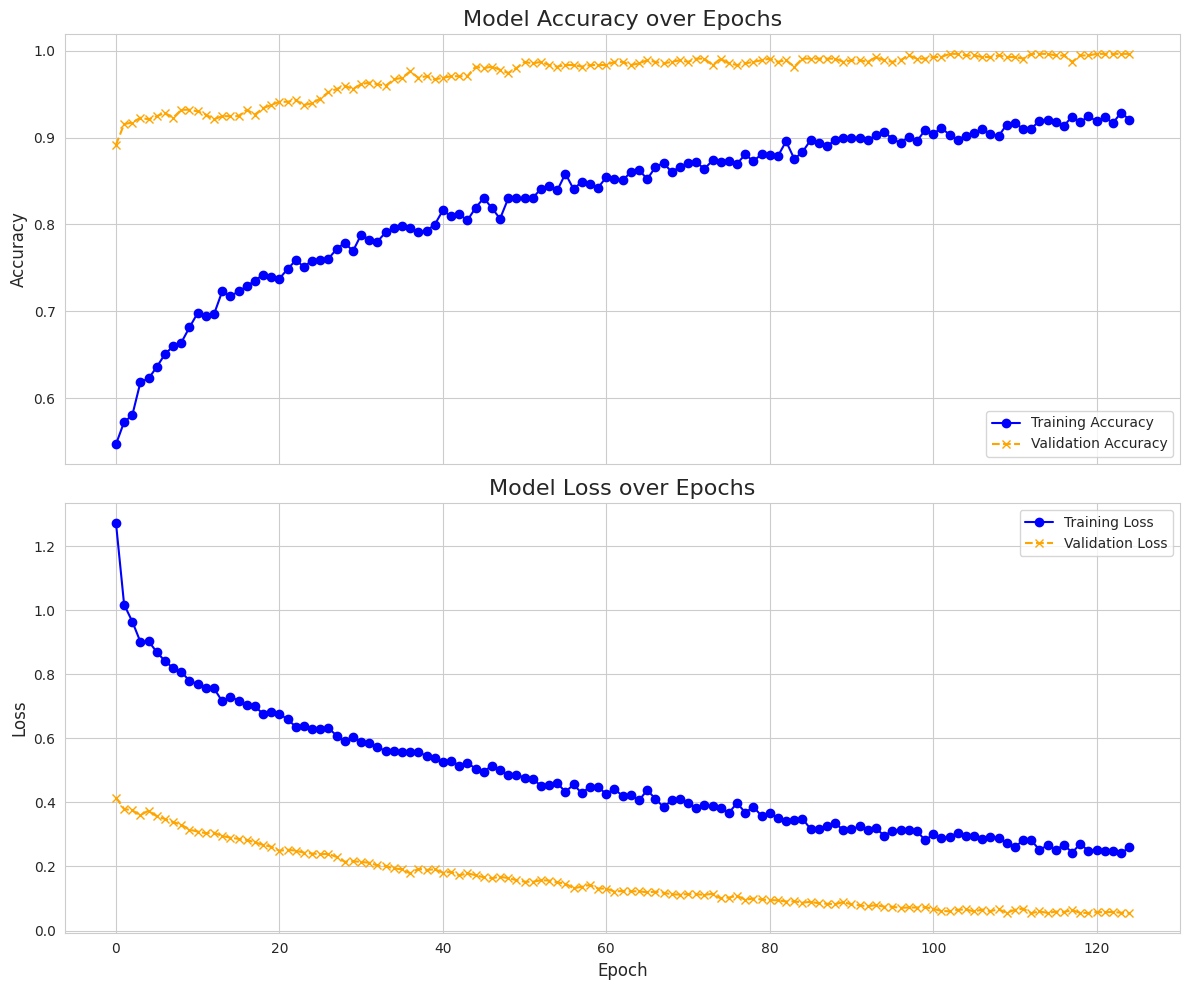

In [ ]:
def run_multiple_trainings(features_df, n_runs=5, test_size=0.2, epochs=300):
    best_result = None
    best_f1 = -1.0

    for i in range(n_runs):
        print(f"\n====== Starting Run {i+1}/{n_runs} ======")
        result = run_lightweight_training(features_df, test_size=test_size, epochs=epochs)

        # Use the average F1 score (normal + anomaly) as the comparison metric
        avg_f1 = (result['normal_metrics']['f1'] + result['anomaly_metrics']['f1']) / 2

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_result = result

            # Save the best model and scaler
            result['model'].save('best_model.h5')
            result['model'].save('best_model.keras')  # Replaces the older version
            joblib.dump(result['scaler'], 'scaler.pkl')
            print(f"\nNew best model saved (Average F1: {avg_f1:.3f})")

    print("\n====== Best Run Summary ======")
    print(f"Best Overall F1: {best_f1:.3f}")
    print(f"Normal F1: {best_result['normal_metrics']['f1']:.3f}")
    print(f"Anomaly F1: {best_result['anomaly_metrics']['f1']:.3f}")

    if best_result and 'history' in best_result:
        plot_training_history(best_result['history'])


    return best_result


best_model_result = run_multiple_trainings(features_df, n_runs=5, test_size=0.2, epochs=300)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
import numpy as np

def random_forest_kfold_detailed(features_df, k=5):
    """Random Forest K-Fold Cross-Validation with Detailed Metrics"""
    print(f"Random Forest K-Fold Validation (k={k})")

    # Prepare data
    feature_cols = [col for col in features_df.columns
                    if col not in ['filename', 'category', 'is_normal', 'fold']]
    X = features_df[feature_cols].values
    y = features_df['is_normal'].values

    print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}, Normal/Anomaly: {np.sum(y==1)}/{np.sum(y==0)}")

    # K-Fold split
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Store metrics
    overall_metrics = {'accuracy': [], 'auc': []}
    normal_metrics = {'precision': [], 'recall': [], 'f1': []}
    anomaly_metrics = {'precision': [], 'recall': [], 'f1': []}

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Normalize
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_train = np.nan_to_num(X_train)
        X_val = np.nan_to_num(X_val)

        # Train model
        rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        rf.fit(X_train, y_train)

        # Predict
        y_pred = rf.predict(X_val)
        y_proba = rf.predict_proba(X_val)[:, 1]

        # Compute metrics
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)

        # Metrics for normal class (label=1)
        normal_prec = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
        normal_rec = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        normal_f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)

        # Metrics for anomaly class (label=0)
        anomaly_prec = precision_score(y_val, y_pred, pos_label=0, zero_division=0)
        anomaly_rec = recall_score(y_val, y_pred, pos_label=0, zero_division=0)
        anomaly_f1 = f1_score(y_val, y_pred, pos_label=0, zero_division=0)

        # Store results
        overall_metrics['accuracy'].append(acc)
        overall_metrics['auc'].append(auc)
        normal_metrics['precision'].append(normal_prec)
        normal_metrics['recall'].append(normal_rec)
        normal_metrics['f1'].append(normal_f1)
        anomaly_metrics['precision'].append(anomaly_prec)
        anomaly_metrics['recall'].append(anomaly_rec)
        anomaly_metrics['f1'].append(anomaly_f1)

        print(f"Fold {fold}: Acc={acc:.3f}, AUC={auc:.3f} | "
              f"Normal P/R/F1={normal_prec:.3f}/{normal_rec:.3f}/{normal_f1:.3f} | "
              f"Anomaly P/R/F1={anomaly_prec:.3f}/{anomaly_rec:.3f}/{anomaly_f1:.3f}")

    # Final result summary
    print(f"\n{'='*60}")
    print("Final Results (Mean ± Std Dev):")
    print(f"{'='*60}")

    print("Overall Metrics:")
    for metric, values in overall_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"  {metric.upper():<8}: {mean_val:.3f} ± {std_val:.3f}")

    print("\nNormal Class (Label=1):")
    for metric, values in normal_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"  {metric.upper():<8}: {mean_val:.3f} ± {std_val:.3f}")

    print("\nAnomaly Class (Label=0):")
    for metric, values in anomaly_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"  {metric.upper():<8}: {mean_val:.3f} ± {std_val:.3f}")

    return {
        'overall': overall_metrics,
        'normal': normal_metrics,
        'anomaly': anomaly_metrics
    }

def get_feature_importance(features_df, top_n=10):
    """Get top-N feature importances using Random Forest"""
    feature_cols = [col for col in features_df.columns
                    if col not in ['filename', 'category', 'is_normal', 'fold']]
    X = features_df[feature_cols].values
    y = features_df['is_normal'].values

    # Data preprocessing
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.nan_to_num(X_scaled)

    # Train model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get importance
    importance = rf.feature_importances_
    indices = np.argsort(importance)[::-1]

    print(f"\nTop {top_n} Important Features:")
    print("-" * 40)
    for i in range(min(top_n, len(feature_cols))):
        idx = indices[i]
        print(f"{i+1:2d}. {feature_cols[idx]:<25}: {importance[idx]:.4f}")

    return list(zip([feature_cols[i] for i in indices], importance[indices]))

# Example usage
if __name__ == "__main__":
    # Run detailed evaluation
    results = random_forest_kfold_detailed(features_df, k=5)

    # Get feature importance
    feature_importance = get_feature_importance(features_df, top_n=15)

Random Forest K-Fold Validation (k=5)
Samples: 2000, Features: 85, Normal/Anomaly: 1440/560
Fold 1: Acc=0.802, AUC=0.843 | Normal P/R/F1=0.803/0.962/0.875 | Anomaly P/R/F1=0.800/0.393/0.527
Fold 2: Acc=0.807, AUC=0.881 | Normal P/R/F1=0.801/0.976/0.879 | Anomaly P/R/F1=0.857/0.375/0.522
Fold 3: Acc=0.790, AUC=0.872 | Normal P/R/F1=0.787/0.972/0.870 | Anomaly P/R/F1=0.818/0.321/0.462
Fold 4: Acc=0.823, AUC=0.897 | Normal P/R/F1=0.816/0.972/0.887 | Anomaly P/R/F1=0.860/0.438/0.580
Fold 5: Acc=0.782, AUC=0.857 | Normal P/R/F1=0.777/0.979/0.866 | Anomaly P/R/F1=0.838/0.277/0.416

Final Results (Mean ± Std Dev):
Overall Metrics:
  ACCURACY: 0.801 ± 0.014
  AUC     : 0.870 ± 0.018

Normal Class (Label=1):
  PRECISION: 0.797 ± 0.014
  RECALL  : 0.972 ± 0.006
  F1      : 0.876 ± 0.007

Anomaly Class (Label=0):
  PRECISION: 0.835 ± 0.023
  RECALL  : 0.361 ± 0.056
  F1      : 0.501 ± 0.057

Top 15 Important Features:
----------------------------------------
 1. rms_mean                 : 0.0292


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import joblib
import scipy.stats
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Load the full Keras model
try:
    keras_model = tf.keras.models.load_model("model/best_model.keras")
    print("Keras model ('best_model.keras') loaded successfully.")
except Exception as e:
    keras_model = None
    print(f"Failed to load Keras model: {e}")

# Load the TensorFlow Lite model and initialize the interpreter
try:
    interpreter = tf.lite.Interpreter(model_path="model/best_model.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("TFLite model ('model/best_model.tflite') loaded successfully.")
except Exception as e:
    interpreter = None
    print(f"Failed to load TFLite model: {e}")

# Load the data scaler
try:
    scaler = joblib.load("scaler.pkl")
    print("Scaler ('scaler.pkl') loaded successfully.")
except Exception as e:
    scaler = None
    print(f"Failed to load Scaler: {e}")

# --- 2. Data Preparation ---
# (This section is the same as your original scripts)
SMART_HOME_CRITICAL_ANOMALIES = [
    'crackling_fire', 'crying_baby', 'sneezing', 'coughing', 'door_knock', 'glass_breaking',
    'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'airplane', 'hand_saw'
]
ALL_ESC50_CATEGORIES = [
    'dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'rain',
    'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds', 'water_drops', 'wind',
    'pouring_water', 'toilet_flush', 'thunderstorm', 'crying_baby', 'sneezing', 'clapping',
    'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring',
    'drinking_sipping', 'door_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks',
    'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick',
    'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train',
    'church_bells', 'airplane', 'fireworks', 'hand_saw'
]
NORMAL_CATEGORIES = [cat for cat in ALL_ESC50_CATEGORIES if cat not in SMART_HOME_CRITICAL_ANOMALIES]

meta_path = "ESC-50-master/meta/esc50.csv"
meta_df = pd.read_csv(meta_path)
meta_df['is_normal'] = meta_df['category'].isin(NORMAL_CATEGORIES).astype(int)
sample_df = meta_df.sample(n=500, random_state=42).reset_index(drop=True)
audio_path = Path("ESC-50-master/audio")
print(f"Data preparation complete. {len(sample_df)} samples selected for validation.")

# --- 3. Feature Extraction Function ---
def extract_comprehensive_features_fast(signal, sr):
    features = {}
    hop_length=512; n_fft=1024
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfcc_stats = np.array([np.mean(mfcc, axis=1), np.std(mfcc, axis=1), scipy.stats.skew(mfcc, axis=1), scipy.stats.kurtosis(mfcc, axis=1)])
    for i in range(13):
        features[f'mfcc_{i}_mean']=mfcc_stats[0,i]; features[f'mfcc_{i}_std']=mfcc_stats[1,i]; features[f'mfcc_{i}_skew']=mfcc_stats[2,i]; features[f'mfcc_{i}_kurt']=mfcc_stats[3,i]
    stft=librosa.stft(signal, hop_length=hop_length, n_fft=n_fft); magnitude=np.abs(stft)
    features['spectral_centroid_mean']=np.mean(librosa.feature.spectral_centroid(S=magnitude, sr=sr)[0]); features['spectral_centroid_std']=np.std(librosa.feature.spectral_centroid(S=magnitude, sr=sr)[0])
    features['spectral_bandwidth_mean']=np.mean(librosa.feature.spectral_bandwidth(S=magnitude, sr=sr)[0]); features['spectral_bandwidth_std']=np.std(librosa.feature.spectral_bandwidth(S=magnitude, sr=sr)[0])
    features['spectral_rolloff_mean']=np.mean(librosa.feature.spectral_rolloff(S=magnitude, sr=sr)[0]); features['spectral_rolloff_std']=np.std(librosa.feature.spectral_rolloff(S=magnitude, sr=sr)[0])
    zcr=librosa.feature.zero_crossing_rate(signal, hop_length=hop_length)[0]; features['zcr_mean']=np.mean(zcr); features['zcr_std']=np.std(zcr)
    rms=librosa.feature.rms(y=signal, hop_length=hop_length)[0]; features['rms_mean']=np.mean(rms); features['rms_std']=np.std(rms)
    contrast=librosa.feature.spectral_contrast(S=magnitude, sr=sr, n_bands=6)
    for i in range(contrast.shape[0]): features[f'contrast_{i}_mean']=np.mean(contrast[i])
    chroma=librosa.feature.chroma_stft(S=magnitude, sr=sr)
    for i in range(12): features[f'chroma_{i}_mean']=np.mean(chroma[i])
    mel_spec=librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=32, hop_length=hop_length, n_fft=n_fft); mel_spec_db=librosa.power_to_db(mel_spec)
    features['mel_mean']=np.mean(mel_spec_db); features['mel_std']=np.std(mel_spec_db); features['mel_max']=np.max(mel_spec_db); features['mel_min']=np.min(mel_spec_db)
    for key, value in features.items():
        if np.isnan(value) or np.isinf(value): features[key]=0.0
    return features

# --- 4. Unified Inference Loop for Both Models ---
results = []
print("\nStarting inference on the same samples for both models...")
if keras_model and interpreter and scaler:
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        filepath = audio_path / row['filename']
        try:
            # Common processing steps
            signal, sr = librosa.load(filepath, sr=16000, duration=5.0)
            features = extract_comprehensive_features_fast(signal, sr)
            X = pd.DataFrame([features])
            X_scaled = scaler.transform(X)
            X_scaled = np.nan_to_num(X_scaled)

            # Keras model inference
            keras_prob = keras_model.predict(X_scaled, verbose=0)[0][0]
            keras_pred = int(keras_prob > 0.5)

            # TFLite model inference
            interpreter.set_tensor(input_details[0]['index'], X_scaled.astype(np.float32))
            interpreter.invoke()
            tflite_prob = interpreter.get_tensor(output_details[0]['index'])[0][0]
            tflite_pred = int(tflite_prob > 0.5)

            results.append({
                'filename': row['filename'],
                'category': row['category'],
                'true_label': row['is_normal'],
                'keras_prob': keras_prob,
                'keras_pred': keras_pred,
                'tflite_prob': tflite_prob,
                'tflite_pred': tflite_pred
            })
        except Exception as e:
            print(f"Skipped {row['filename']} due to error: {e}")

    results_df = pd.DataFrame(results)

    # --- 5. Side-by-Side Comparative Results Display ---
    print("\n\n" + "="*80)
    print("Keras vs. TFLite Model Performance Comparison")
    print(f"(Metrics calculated for the 'Normal' class, pos_label=1, on {len(results_df)} samples)")
    print("="*80)

    y_true = results_df['true_label'].values
    y_pred_keras = results_df['keras_pred'].values
    y_pred_tflite = results_df['tflite_pred'].values

    # Calculate metrics for Keras model
    acc_keras = accuracy_score(y_true, y_pred_keras)
    prec_keras = precision_score(y_true, y_pred_keras, pos_label=1, zero_division=0)
    rec_keras = recall_score(y_true, y_pred_keras, pos_label=1, zero_division=0)
    f1_keras = f1_score(y_true, y_pred_keras, pos_label=1, zero_division=0)

    # Calculate metrics for TFLite model
    acc_tflite = accuracy_score(y_true, y_pred_tflite)
    prec_tflite = precision_score(y_true, y_pred_tflite, pos_label=1, zero_division=0)
    rec_tflite = recall_score(y_true, y_pred_tflite, pos_label=1, zero_division=0)
    f1_tflite = f1_score(y_true, y_pred_tflite, pos_label=1, zero_division=0)

    # Print comparison table
    print(f"{'Metric':<22} | {'Keras Model (.keras)':<25} | {'TFLite Model (.tflite)':<25}")
    print("-" * 80)
    print(f"{'Accuracy':<22} | {acc_keras:<25.3f} | {acc_tflite:<25.3f}")
    print(f"{'Precision (Normal)':<22} | {prec_keras:<25.3f} | {prec_tflite:<25.3f}")
    print(f"{'Recall (Normal)':<22} | {rec_keras:<25.3f} | {rec_tflite:<25.3f}")
    print(f"{'F1-Score (Normal)':<22} | {f1_keras:<25.3f} | {f1_tflite:<25.3f}")
    print("-" * 80)

    # Calculate and print prediction consistency
    consistency = np.mean(results_df['keras_pred'] == results_df['tflite_pred'])
    print(f"\nPrediction Consistency: {consistency:.1%}")
    print("(The percentage of samples where both models gave the same prediction)")

    # Print confusion matrices
    cm_keras = confusion_matrix(y_true, y_pred_keras)
    cm_tflite = confusion_matrix(y_true, y_pred_tflite)
    print("\nKeras Confusion Matrix (rows=true, cols=predicted):\n", cm_keras)
    print("\nTFLite Confusion Matrix (rows=true, cols=predicted):\n", cm_tflite)
else:
    print("\nCould not run comparison due to errors in loading models or scaler.")

Keras model ('best_model.keras') loaded successfully.
TFLite model ('model/best_model.tflite') loaded successfully.
Scaler ('scaler.pkl') loaded successfully.
Data preparation complete. 500 samples selected for validation.

Starting inference on the same samples for both models...


100%|██████████| 500/500 [04:15<00:00,  1.96it/s]



Keras vs. TFLite Model Performance Comparison
(Metrics calculated for the 'Normal' class, pos_label=1, on 500 samples)
Metric                 | Keras Model (.keras)      | TFLite Model (.tflite)   
--------------------------------------------------------------------------------
Accuracy               | 0.974                     | 0.974                    
Precision (Normal)     | 0.989                     | 0.989                    
Recall (Normal)        | 0.976                     | 0.976                    
F1-Score (Normal)      | 0.982                     | 0.982                    
--------------------------------------------------------------------------------

Prediction Consistency: 100.0%
(The percentage of samples where both models gave the same prediction)

Keras Confusion Matrix (rows=true, cols=predicted):
 [[123   4]
 [  9 364]]

TFLite Confusion Matrix (rows=true, cols=predicted):
 [[123   4]
 [  9 364]]
